In this notebook we're creating a CNN to compare it with GCN

In [1]:
# import necessary stuff for
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sentence_transformers import SentenceTransformer

import re
import ast

h:\dev\NLP\GNN_application_in_hate_speech_detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pandas setup

In [2]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 10)  # Limit number of rows displayed
pd.set_option('display.width', 1000)  # Set max width for table
pd.set_option('display.colheader_justify', 'center')  # Center-align column headers

In [3]:
def clean_special_chars(value):
    if isinstance(value, str):  
        return value.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').replace('  ', ' ').strip()
    return value 

Reading gab

In [4]:
content_gab = pd.read_csv('gab_reddit_benchmark/gab.csv')

content_gab["text"] = content_gab["text"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 
content_gab["response"] = content_gab["response"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="")
content_gab["hate_speech_idx"] = content_gab["hate_speech_idx"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 

# content_gab["text"] = content_gab["text"].apply(clean_special_chars)
# content_gab["response"] = content_gab["response"].apply(clean_special_chars)

for index, row in content_gab.iterrows():
    row['text'] = row['text'].replace("'", '"')
    row['response'] = row['response'].replace("'", '"')

# content_gab = content_gab.applymap(clean_special_chars)
print(content_gab.head(n=10))
print('\n- - - - - -\n')
print(content_gab.columns)
print('\n- - - - - -\n')
print(content_gab.iloc[1]['id'])

                          id                                                text                        hate_speech_idx                      response                     
0                                    1. 39869714\r\n  1. i joined gab to remind myself how retarded ...         [1]      ["Using words that insult one group while defe...
1  1. 39845588\r\n2. \t39848775\r\n3. \t\t3991101...  1. This is what the left is really scared of. ...         [3]      ['You can disagree with someones opinion witho...
2                   1. 37485560\r\n2. \t37528625\r\n  1. It makes you an asshole.\r\n2. \tGive it to...         [2]      ['Your argument is more rational if you leave ...
3                   1. 39787626\r\n2. \t39794481\r\n  1. So they manage to provide a whole lot of da...         [2]      ["You shouldn't generalize a specific group or...
4  1. 37957930\r\n2. \t39953348\r\n3. \t\t3996521...  1. Hi there, i,m Keith, i hope you are doing w...         [3]      ['If someone is rude it 

Merge posts

In [5]:

def get_first_number(input_string):
    match = re.search(r'\d{2,}', input_string)
    if match:
        return int(match.group())
    return None

content_gab['extracted_id'] = content_gab['id'].apply(get_first_number)

# Find duplicate rows based on 'extracted_id'
duplicates = content_gab[content_gab.duplicated(subset=['extracted_id'], keep=False)]
filtered_groups = []
grouped = content_gab.groupby('extracted_id')
for key, group in grouped:
    if len(group) > 1:
        filtered_groups.append(group)

merged_df = pd.concat(filtered_groups, ignore_index=True)

merged_df.to_csv('gab_reddit_benchmark/gab_groups.csv', index=False)

merged_df = grouped.agg({
    'id': ' '.join,
    'text': ' '.join,
    'hate_speech_idx': ' '.join,
    'response': ' '.join
}).reset_index()
merged_df.to_csv('gab_reddit_benchmark/gab_merged.csv')

df = pd.read_csv('gab_reddit_benchmark/gab_merged.csv')
df = df.applymap(lambda x: x.replace('] [', ', ') if isinstance(x, str) else x)
df = df.applymap(lambda x: x.replace(']  [', ', ') if isinstance(x, str) else x)
df = df.applymap(lambda x: 'n/a' if isinstance(x, str) and x.strip() == '' else x)
df.to_csv('gab_reddit_benchmark/gab_merged.csv', index=False)

C:\Users\Wrobl\AppData\Local\Temp\ipykernel_7580\2213304540.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace('] [', ', ') if isinstance(x, str) else x)
C:\Users\Wrobl\AppData\Local\Temp\ipykernel_7580\2213304540.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace(']  [', ', ') if isinstance(x, str) else x)
C:\Users\Wrobl\AppData\Local\Temp\ipykernel_7580\2213304540.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 'n/a' if isinstance(x, str) and x.strip() == '' else x)


In [6]:
content_gab_m = pd.read_csv('gab_reddit_benchmark/gab_merged.csv')
content_gab_m = content_gab_m.drop('Unnamed: 0', axis=1)
content_gab_m = content_gab_m.drop('extracted_id', axis=1)


content_gab_m["text"] = content_gab_m["text"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 
content_gab_m["response"] = content_gab_m["response"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="")
content_gab_m["hate_speech_idx"] = content_gab_m["hate_speech_idx"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 

for index, row in content_gab_m.iterrows():
    row['text'] = row['text'].replace("'", '"')
    row['response'] = row['response'].replace("'", '"')

print(content_gab_m.head(n=10))
print('\n- - - - - -\n')
print(content_gab_m.columns)
print('\n- - - - - -\n')
print(content_gab_m.iloc[0]['id'])

                          id                                                text                        hate_speech_idx                      response                     
0  1. 37011807\r\n2. \t37012801\r\n3. \t\t3701333...  1. 64% of Hispanics have IQ scores too low to ...     [2, 2, 3]    ['Racist and hate speech will not be tolerated...
1                    1. 37012081\r\n 1. 37012081\r\n  1. LYING CUNT BITCH !!\r\n 1. LYING CUNT BITCH...        [1, 1]    ['Please refrain from using derogatory terms f...
2                                    1. 37012105\r\n  1. Nigger Kills 2 cops https://www.google.com/...           [1]    ['The N word is highly offensive.   All ethnic...
3                   1. 37012146\r\n2. \t37013020\r\n  1. STABBED IN NECK   arrested but no descr   #...           [2]    ['Use of the n-word is unacceptable in our dis...
4  1. 37012285\r\n2. \t37013809\r\n3. \t37013868\r\n  1. Retard 1st Class  w/ Cluster & Ribbon\r\n2....           [1]    ['We should try and not 

In [7]:
def mark_text_labels(text_utterances_length, labels):
    if not labels:
        # return ['other'] * text_utterances_length
        return [0] * text_utterances_length
    new_labels = []
    int_list = ast.literal_eval(labels)
    for i in range(text_utterances_length):
        if i+1 in int_list:
            # new_labels.append('hate_speech')
            new_labels.append(1)
        else:
            # new_labels.append('other')
            new_labels.append(0)
    return new_labels

Splitting 'text' and 'response'

In [8]:
text_column = []
text_labels_column = []
response_column = []
response_labels_column = []

for index, row in content_gab.iterrows():
    text_utterances = row['text'].split('\n')
    text_utterances = list(filter(None, text_utterances))

    for i, t in enumerate(text_utterances):
        text_utterances[i] = clean_special_chars(t)
    text_labels = mark_text_labels(len(text_utterances), row['hate_speech_idx'])

    response_utterances = ast.literal_eval(row['response']) if row['response'] else []
    for i, r in enumerate(response_utterances):
        response_utterances[i] = clean_special_chars(r)
    # response_labels = ['other'] * len(response_utterances)  
    response_labels = [0] * len(response_utterances)  

    
    text_column.append(text_utterances)
    text_labels_column.append(text_labels)
    response_column.append(response_utterances)
    response_labels_column.append(response_labels)

content_gab['text'] = text_column
content_gab['hate_speech_idx'] = text_labels_column
content_gab['response'] = response_column
content_gab['response_labels'] = response_labels_column

content_gab = content_gab.rename(columns={'hate_speech_idx': 'text_labels'})
print(content_gab.head())
print('- - - - ')
print(content_gab.columns)

for index, row in content_gab.iterrows():
    if index == 1:
        continue
    print(row['id'], row['text'], row['text_labels'], row['response'], row['response_labels'])
    break

                          id                                                text                        text_labels                      response                       extracted_id response_labels
0                                    1. 39869714\r\n  [1. i joined gab to remind myself how retarded...         [1]  [Using words that insult one group while defen...    39869714       [0, 0, 0]  
1  1. 39845588\r\n2. \t39848775\r\n3. \t\t3991101...  [1. This is what the left is really scared of....   [0, 0, 1]  [You can disagree with someones opinion withou...    39845588       [0, 0, 0]  
2                   1. 37485560\r\n2. \t37528625\r\n  [1. It makes you an asshole., 2. Give it to a ...      [0, 1]  [Your argument is more rational if you leave y...    37485560       [0, 0, 0]  
3                   1. 39787626\r\n2. \t39794481\r\n  [1. So they manage to provide a whole lot of d...      [0, 1]  [You shouldn't generalize a specific group or ...    39787626       [0, 0, 0]  
4  1. 37957930\

In [9]:
# get text, first label, response, first response label for each row
texts = []
text_labels = []
for index, row in content_gab.iterrows():
    for i, t in enumerate(row['text']):
        texts.append(t)
        text_labels.append(row['text_labels'][i])

Defining BERT

In [10]:
bert = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embeddings(sentences):
    if isinstance(sentences, list):
        return bert.encode(sentences, show_progress_bar=True).tolist()
    elif isinstance(sentences, str):
        return bert.encode([sentences], show_progress_bar=True).tolist()
    return []

Generate embeddings

In [11]:
# content_gab = content_gab[:200]
# before = time.time()
# content_gab['text_embeddings'] = content_gab['text'].apply(generate_embeddings)
# after_text = time.time()
# print(content_gab.iloc[1]['text_embeddings'])
# print('\nTIME FOR TEXT EMBEDDINGS: ', after_text - before)
# print('\n- - - - - -\n')
# content_gab['response_embeddings'] = content_gab['response'].apply(generate_embeddings)
# after_response = time.time()
# print(content_gab.iloc[2]['response_embeddings'])
# print('\nTIME FOR RESPONSE EMBEDDINGS: ', after_response - after_text)
# print('\n- - - - - -\n')
# embed texts
before = time.time()
text_embeddings = generate_embeddings(texts)
after_text = time.time()
print('\nTIME FOR TEXT EMBEDDINGS: ', after_text - before)
print('\n- - - - - -\n')



Batches: 100%|██████████| 1056/1056 [00:10<00:00, 98.12it/s] 



TIME FOR TEXT EMBEDDINGS:  11.327555179595947

- - - - - -



Prepare labels

In [12]:
# make dataset from embeddings and labels
class GabDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# split data into train and test
text_embeddings = np.array(text_embeddings)
text_labels = np.array(text_labels)

text_embeddings = np.stack(text_embeddings, axis=0)
text_labels = np.stack(text_labels, axis=0)

X_train, X_test, y_train, y_test = train_test_split(text_embeddings, text_labels, test_size=0.2, random_state=42)

print('Train data:', len(X_train), len(y_train))
print('Test data:', len(X_test), len(y_test))

# create dataset
train_dataset = GabDataset(X_train, y_train)
test_dataset = GabDataset(X_test, y_test)

print(train_dataset[0])
print(test_dataset[0])

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Train data: 27020 27020
Test data: 6756 6756
(array([-3.44326384e-02, -2.18355618e-02,  7.33759627e-02,  3.13405097e-02,
       -1.66528411e-02, -4.02435921e-02,  1.23953640e-01, -5.40787540e-02,
        1.17365345e-01,  3.48896198e-02,  4.76283766e-02, -1.34696305e-01,
        6.20039515e-02, -6.48817271e-02,  9.58839548e-04,  3.08414735e-02,
       -3.19390707e-02, -5.50945699e-02, -9.64566618e-02,  4.76733781e-03,
       -1.00273183e-02, -1.01099841e-01, -2.89843939e-02, -6.20556399e-02,
       -1.00673907e-01, -6.28759339e-02,  2.01311186e-02,  4.61148005e-03,
       -4.59683761e-02,  4.29530814e-03, -6.55897986e-03,  5.86478934e-02,
        1.49863232e-02, -5.21263620e-03,  5.80718927e-03, -3.22730951e-02,
       -6.03998918e-03,  4.06275280e-02, -1.64304469e-02,  2.99233347e-02,
       -9.05553475e-02, -2.32283920e-02,  3.35135162e-02,  7.70595670e-02,
        1.80413574e-02,  3.54835130e-02,  7.96923786e-02,  7.17390701e-02,
       -1.62498638e-01, -6.56728223e-02, -8.81093815e-

Define a CNN

Epoch: 000, Loss: 0.3378, Test Accuracy: 0.8730
Epoch: 001, Loss: 0.2966, Test Accuracy: 0.8795
Epoch: 002, Loss: 0.2843, Test Accuracy: 0.8831
Epoch: 003, Loss: 0.2735, Test Accuracy: 0.8837
Epoch: 004, Loss: 0.2630, Test Accuracy: 0.8890
Epoch: 005, Loss: 0.2525, Test Accuracy: 0.8881
Epoch: 006, Loss: 0.2429, Test Accuracy: 0.8881
Epoch: 007, Loss: 0.2335, Test Accuracy: 0.8933
Epoch: 008, Loss: 0.2232, Test Accuracy: 0.8928
Epoch: 009, Loss: 0.2136, Test Accuracy: 0.8931
Epoch: 010, Loss: 0.2040, Test Accuracy: 0.8882
Epoch: 011, Loss: 0.1949, Test Accuracy: 0.8925
Epoch: 012, Loss: 0.1851, Test Accuracy: 0.8905
Epoch: 013, Loss: 0.1761, Test Accuracy: 0.8906
Epoch: 014, Loss: 0.1675, Test Accuracy: 0.8893
Epoch: 015, Loss: 0.1577, Test Accuracy: 0.8903
Epoch: 016, Loss: 0.1498, Test Accuracy: 0.8899
Epoch: 017, Loss: 0.1404, Test Accuracy: 0.8896
Epoch: 018, Loss: 0.1319, Test Accuracy: 0.8850
Epoch: 019, Loss: 0.1247, Test Accuracy: 0.8897
Epoch: 020, Loss: 0.1160, Test Accuracy:

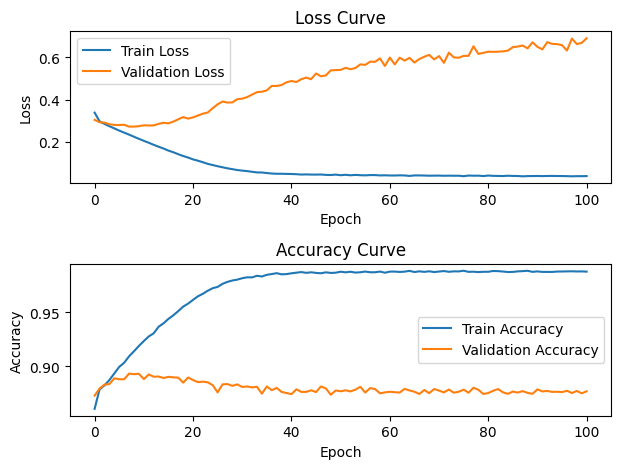

In [ ]:
input_dim = len(train_dataset[0][0])
sequence_length = len(train_dataset[0][0])

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)
    
model = MLPClassifier(input_dim=input_dim)

# define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
epochs_num = 101

# train model
def train():
    correct = 0
    total = 0
    total_loss = 0
    model.train()
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        inputs = inputs.float()
        labels = labels.long()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().reshape(-1, 1))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0) 
        predicted = (outputs >= 0.5).long().reshape(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = total_loss / total
    train_acc = correct / total
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    
    return train_loss


def test():
    model.eval()
    correct = 0
    total = 0
    total_loss = 0  
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float()
            labels = labels.long()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().reshape(-1, 1)) 
            
            total_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).long().reshape(-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = total_loss / total
    test_acc = correct / total
    
    val_acc_list.append(test_acc)
    val_loss_list.append(test_loss)
    
    return test_acc

    
for i in range(epochs_num):
    loss = train()
    test_acc = test()
    print(f'Epoch: {i:03d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

# class CNN(nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=hidden_channels, kernel_size=2)
#         self.conv2 = nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=2)
        
#     def forward(self, x):
#         x = x.unsqueeze(1)
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         return x

# # Adjust kernel size to 2
# model = CNN(hidden_channels=16)
# print(model)

# # define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # train model
# def train(model, train_loader, criterion, optimizer, num_epochs=5):
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for i, data in enumerate(train_loader):
#             inputs, labels = data
#             optimizer.zero_grad()
#             inputs = torch.tensor(inputs).float()
#             labels = torch.tensor(labels).long()
#             outputs = model(inputs)
#             print(outputs.shape)
#             print(labels.shape)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#             if i % 100 == 99:
#                 print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
#                 running_loss = 0.0

# train(model, train_loader, criterion, optimizer, num_epochs=101)

# # test model
# def test(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in test_loader:
#             inputs, labels = data
#             inputs = torch.tensor(inputs).float().permute(0, 2, 1)
#             labels = torch.tensor(labels).long()
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))

# test(model, test_loader)

In [18]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

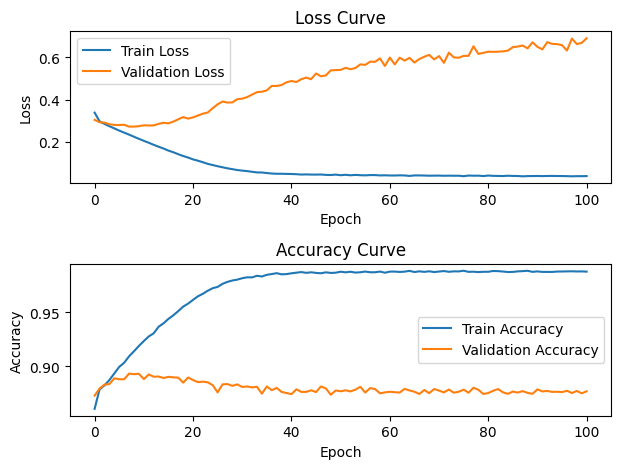

In [73]:
# Plot the results
plt.subplot(2,1,1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.subplot(2,1,2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()

plt.savefig('./MLPClassifier')
plt.show()


In [74]:
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8770
